# <center> Задание 1

## Библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import numpy as np
from sklearn import (cluster, 
                     metrics,
                     decomposition)
import glob
import os
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arkad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Данные

Данные берем с сайта "Работа России". Ссылка на сайт - https://trudvsem.ru/opendata/api

За раз можно получать не более 100 записей на странице. В запросе есть два параметра число элементов (limit) и смещение (offset).

In [2]:
%%time
# Напишем логику получения необходимого количества данных.
limit = 100
offset = 0
i = 0 # для счетчика 
ls_job_names = [] # список, куда будем записывать профессии
total_quantity = 5000 # количество записей для анализа
div = total_quantity // limit
while i < div:
    url = 'http://opendata.trudvsem.ru/api/v1/vacancies?' + 'offset=' + str(offset + 100*i) + '&limit=' + str(limit) # все вакансии
    # url = 'http://opendata.trudvsem.ru/api/v1/vacancies/region/77?' + 'offset=' + str(offset + 100*i) + '&limit=' + str(limit) # вакансии по региону
    response = requests.get(url).json()
    for j in range(limit):
        # Достаем профессию.
        job_name = response['results']['vacancies'][j]['vacancy']['job-name'].lower()
        ls_job_names.append(job_name)
    i += 1

CPU times: total: 0 ns
Wall time: 1min 24s


In [3]:
# Сохраним данные в файл.
with open('data_vacancy', 'w', encoding='utf-8') as file:
    for item in ls_job_names:
        file.write(item + '\n')

## Обработка полученных данных

In [4]:
# Прочитаем данные из файла.
with open('data_vacancy', 'r', encoding='utf-8') as file:
    my_list = file.read().splitlines()

print(my_list[:5])
print(len(my_list))

['ветеринарный врач', 'старший менеджер/менеджер в команду strategy & operations', 'старший консультант в команду strategy & operations', 'старший менеджер в команду стратегического и операционного консалтинга, сектор энергетики', 'грузчик']
5000


Так как профессий Data Scientist, Data Analyst, Data Engineer здесь не оказалось, то для примера найдем другие профессии.

In [5]:
# Создадим ключи по которым будут формироваться списки.
ls_ing_pto = ['инженер', 'пто']
ls_ing_builder = ['инженер', 'строитель']
driver_loader = ['водитель', 'погрузчика']
truck_driver = ['водитель', 'грузового', 'автомобиля']

In [6]:
# Сформируем списки.
filter_ls_ing_pto = [s for s in my_list if all(keyword in s for keyword in ls_ing_pto)]
filter_ls_ing_builder = [s for s in my_list if all(keyword in s for keyword in ls_ing_builder)]
filter_driver_loader = [s for s in my_list if all(keyword in s for keyword in driver_loader)]
filter_truck_driver = [s for s in my_list if all(keyword in s for keyword in truck_driver)]

In [7]:
# Для упрощения примера, заменим все значения одинаковыми выражениями.
filter_ls_ing_pto = ['инженер пто' for word in filter_ls_ing_pto]
filter_ls_ing_builder = ['инженер строитель' for word in filter_ls_ing_builder]
filter_driver_loader = ['водитель погрузчика' for word in filter_driver_loader]
filter_truck_driver = ['водитель грузового автомобиля' for word in filter_truck_driver]

In [8]:
# Объединим списки по водителям и инженерам.
ing = filter_ls_ing_pto + filter_ls_ing_builder
driver = filter_driver_loader + filter_truck_driver
# Так как списки разной длины.
max_length = max(len(ing), len(driver))
ing += [None] * (max_length - len(ing))
driver += [None] * (max_length - len(driver))
# Объединяем в датафрейм.
df_t = pd.DataFrame({
    'инженеры' : ing,
    'водители' : driver
})
display(df_t.head(2))
display(df_t.tail(2))

,инженеры,водители
0,инженер пто,водитель погрузчика
1,инженер пто,водитель погрузчика


,инженеры,водители
15,None,водитель грузового автомобиля
16,None,водитель грузового автомобиля


## Визуализация

In [9]:
# Преобразуем датафрейм в сводную таблицу.
melted_df = df_t.melt(var_name='профессия', value_name='тип профессии')
pivot_table = melted_df.pivot_table(index='профессия', columns='тип профессии', aggfunc='size')

In [10]:
pivot_table

тип профессии,водитель грузового автомобиля,водитель погрузчика,инженер пто,инженер строитель
профессия,,,,
водители,4.0,13.0,NaN,NaN
инженеры,NaN,NaN,4.0,6.0


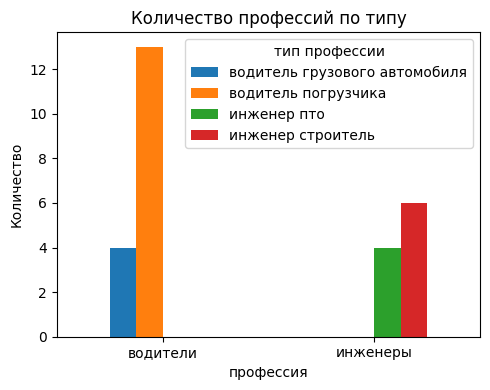

In [11]:
# Постоим столбчатую диаграмму.
pivot_table.plot(kind='bar', figsize=(5, 4))
plt.title('Количество профессий по типу')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.tight_layout();

По этой же логике можно доставать данные по другим профессиям и с других сайтов. 

# <center> Задание 2

## Данные

In [12]:
# Папка лежит где и файл выполнения тестового задания.
path = 'sampled_texts'
# Создадим список.
txt_files = glob.glob(os.path.join(path, '*.txt'))

data = []
for file_path in txt_files:
    # Прочитаем данные из файла.
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        data.append(text)

In [13]:
df = pd.DataFrame(data, columns=['text'])
display(df.head())
# print(df.info())

,text
0,Topic: Ottawa Says Time to Stop Protecting Air...
1,"Topic: Wall Street Faces 2 Elections, Not Just..."
2,Topic: White House Rejects Trade Case Vs. Chin...
3,Topic: BA launches inquiry\n\nText: The chief ...
4,Topic: Technology ; Fans Throng for First Crac...


## Предобработка текста

In [14]:
stop_words = set(stopwords.words('english'))

def prepross_text(line):
    '''Функция осуществляет препроцессинг текста.'''
    
    # Почистим строку от пунктуации, переведем в нижний регистр и токенизируем.
    exclude = set(string.punctuation)
    spls = ''.join(i for i in line.strip() if i not in exclude).lower().split()
    # Уберем стоп-слова.
    spls = [i for i in spls if i not in stop_words and i != '']
    
    return spls

In [15]:
# Сделаем препроцессинг текста.
df['text'] = df['text'].apply(lambda x: prepross_text(x))
display(df.head())

,text
0,"[topic, ottawa, says, time, stop, protecting, ..."
1,"[topic, wall, street, faces, 2, elections, 1, ..."
2,"[topic, white, house, rejects, trade, case, vs..."
3,"[topic, ba, launches, inquiry, text, chief, ex..."
4,"[topic, technology, fans, throng, first, crack..."


## Эмбединги

In [16]:
model = Word2Vec(sentences=df['text'], vector_size=100, window=5, min_count=1, workers=4)

In [17]:
def get_word_vectors(words):
    '''Функция преобразует слова в агрегированные эмбеддинги.'''
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0).tolist() if vectors else None

df['embeddihgs'] = df['text'].apply(get_word_vectors)
display(df.head(3))

,text,embeddihgs
0,"[topic, ottawa, says, time, stop, protecting, ...","[-0.00014023251424077898, 0.001634018146432936..."
1,"[topic, wall, street, faces, 2, elections, 1, ...","[-0.00044946660636924207, 0.000401713303290307..."
2,"[topic, white, house, rejects, trade, case, vs...","[0.00036711644497700036, -0.000181855910341255..."


In [18]:
# Переведем данные в массив.
X = np.array(df['embeddihgs'].to_list())

## Кластеризация. KMEAN. Метод локтя

In [19]:
def get_inertia(cluster_num, X):
    '''Функция принимает количество кластеров и матрицу с признаками и возвращает инерцию.'''
    
    kmeans = cluster.KMeans(n_clusters=cluster_num, init='k-means++', random_state=13)
    kmeans.fit(X)
    inertia = kmeans.inertia_
    
    return inertia

In [20]:
inertia = []
for cluster_num in range(1, 20):
    inertia.append(get_inertia(cluster_num, X))

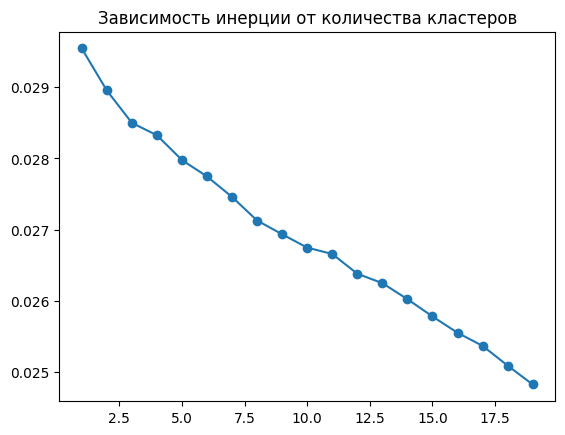

In [21]:
plt.plot([i for i in range(1, 20)], inertia, marker='o')
plt.title('Зависимость инерции от количества кластеров');

Метод ллоктя оказался не информативен (добавляя количество кластеров картина не меняется).

## Кластеризация. KMEAN. Коэффициент силуета

In [22]:
def get_silgouette(cluster_num, X):
    '''Функция считает метод логтя.'''
    
    kmeans = cluster.KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=13)
    kmeans.fit(X)
    silhouette = metrics.silhouette_score(X, kmeans.predict(X))
    
    return silhouette

In [23]:
silgouette_dic = {'silgouette' : [], 'cluster' : []}
for cluster_num in range(2, 30):
    silgouette_dic['silgouette'].append(get_silgouette(cluster_num, X))
    silgouette_dic['cluster'].append(cluster_num)
    
silgouette_df = pd.DataFrame(silgouette_dic)

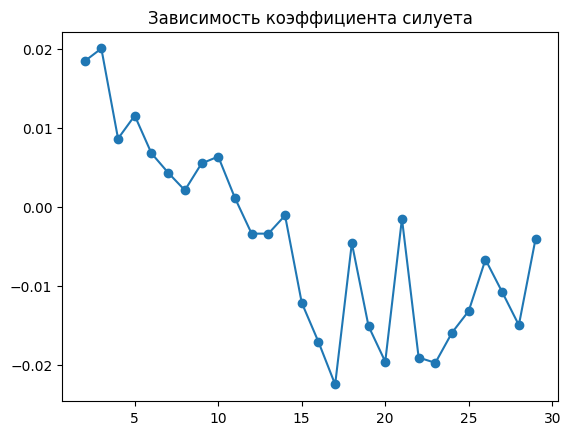

In [24]:
plt.plot(silgouette_df['cluster'], silgouette_df['silgouette'], marker='o')
plt.title('Зависимость коэффициента силуета');

Коэффициент силуета так же не информативен.

## Кластеризация. DBSCAN

In [25]:
# Понизим размерность до 2, чтобы визуализировать.
pca = decomposition.PCA(n_components=2, random_state=13)
emb_2d = pd.DataFrame(pca.fit_transform(X), columns=['x1', 'x2'])

In [26]:
df = pd.concat([df, emb_2d], axis=1)
display(df.head())

,text,embeddihgs,x1,x2
0,"[topic, ottawa, says, time, stop, protecting, ...","[-0.00014023251424077898, 0.001634018146432936...",0.002677,0.001227
1,"[topic, wall, street, faces, 2, elections, 1, ...","[-0.00044946660636924207, 0.000401713303290307...",-0.000436,-0.000817
2,"[topic, white, house, rejects, trade, case, vs...","[0.00036711644497700036, -0.000181855910341255...",0.001137,-0.000403
3,"[topic, ba, launches, inquiry, text, chief, ex...","[-0.0023017949424684048, -0.001564179197885096...",0.001050,-0.000423
4,"[topic, technology, fans, throng, first, crack...","[-0.00026988337049260736, 0.001042797579430043...",-0.000258,-0.001181
...,...,...,...,...
195,"[topic, thaksin, vows, 39iron, fist, 39, rebel...","[-0.001050925231538713, -0.0003205841057933867...",-0.000129,0.000172
196,"[topic, ibm, 8217s, atlantic, tools, platform,...","[-0.001217862474732101, 0.0020063009578734636,...",0.000319,-0.002966
197,"[topic, second, andre, win, row, boosts, us, g...","[-0.002504618838429451, 0.0013441074406728148,...",0.001933,-0.002190
198,"[topic, brown, struggles, early, yankees, end,...","[-0.00035621842835098505, 0.001143098226748406...",-0.001191,-0.001895


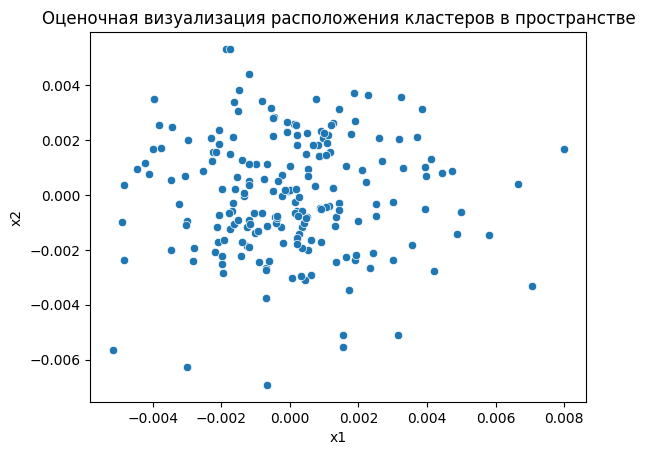

In [27]:
sns.scatterplot(data=emb_2d, x='x1', y='x2')
plt.title('Оценочная визуализация расположения кластеров в пространстве');

По графику видно, что эмбеггинги можно разделить на кластеры.

In [28]:
# Иницианализируем модель кластеризации на основе плотности.
clustering = cluster.DBSCAN(eps=0.0003, min_samples=3).fit(emb_2d)
df['label'] = clustering.labels_
print(f'Количество кластеров - {df['label'].nunique()}')

Количество кластеров - 18


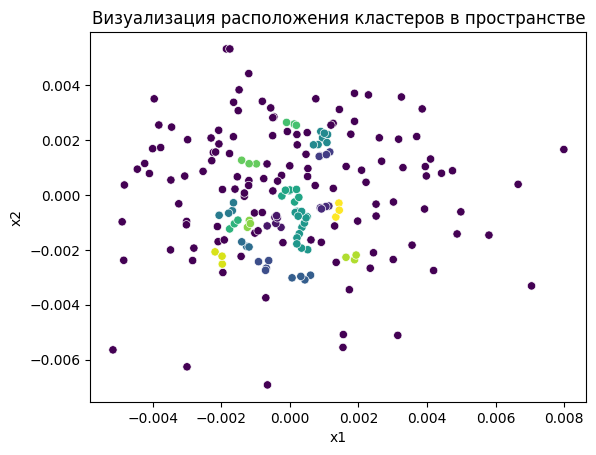

In [29]:
sns.scatterplot(data=emb_2d, x='x1', y='x2', c=clustering.labels_)
plt.title('Визуализация расположения кластеров в пространстве');

In [30]:
display(df.head())

,text,embeddihgs,x1,x2,label
0,"[topic, ottawa, says, time, stop, protecting, ...","[-0.00014023251424077898, 0.001634018146432936...",0.002677,0.001227,-1
1,"[topic, wall, street, faces, 2, elections, 1, ...","[-0.00044946660636924207, 0.000401713303290307...",-0.000436,-0.000817,0
2,"[topic, white, house, rejects, trade, case, vs...","[0.00036711644497700036, -0.000181855910341255...",0.001137,-0.000403,1
3,"[topic, ba, launches, inquiry, text, chief, ex...","[-0.0023017949424684048, -0.001564179197885096...",0.001050,-0.000423,1
4,"[topic, technology, fans, throng, first, crack...","[-0.00026988337049260736, 0.001042797579430043...",-0.000258,-0.001181,0


# Классификация новых документов

In [31]:
def classifiy_new_doc(new_text, df):
    '''Функция классифицирует новый документ.'''
    
    # Получаем эмбеддинг для нового текста.
    new_embeddings = get_word_vectors(new_text)
    
    # Создаем список кластеров и их средних.
    cluster_embeddings = {}
    for label in df['label'].unique():
        if label != -1:
            embeddighs_in_cluster = np.array(df[df['label'] == label]['embeddihgs'].tolist())
            cluster_embeddings[label] = embeddighs_in_cluster.mean(axis=0)
            
    # Находим ближайший кластер.
    closest_cluster = None
    closest_distance = float('inf')
    
    for label, cluster_embeddings in cluster_embeddings.items():
        distance = metrics.pairwise.cosine_similarity([new_embeddings], [cluster_embeddings])[0][0]
        if distance < closest_distance:
            closest_distance = distance
            closest_cluster = label
            
    return closest_cluster

In [32]:
new_text = 'ValueError: setting an array element with a sequence.'
closest_cluster = classifiy_new_doc(new_text, df)
print(f'Новый текст отнесен к кластеру: {closest_cluster}')

Новый текст отнесен к кластеру: 12
